In [1]:
import os

import tensorflow as tf
import keras
import matplotlib.pyplot as plt

E0000 00:00:1732047810.332234   25429 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732047810.376916   25429 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
def convert_model(_model, path):
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()

    with open(path, 'wb') as f:
        f.write(tflite_model)

def generate_cpp(path):
    var_names = (
        path.replace("/", "_").replace(".", "_"),
        path.replace("/", "_").replace(".", "_") + "_len"
    )
    cpp_path = path.replace(".tflite", ".cpp")
    os.system(f'xxd -i {path} > {cpp_path}')

    with open(cpp_path, 'r') as f:
        cpp_text = f.read()

    h_path = cpp_path.replace(".cpp", ".h")
    with open(h_path, 'w') as f:
        f.write(f"extern unsigned char {var_names[0]}[];\n")
        f.write(f"extern unsigned int {var_names[1]};")

    h_name = h_path.split("/")[-1]
    with open(cpp_path, "w") as f:
        f.write(f'#include "{h_name}"\n\n' + cpp_text)

def get_evaluation(model, history, epochs, x_test, y_test, path):
    train_loss = history['loss']
    val_loss = history['val_loss']

    train_acc = history['sparse_categorical_accuracy']
    val_acc = history['val_sparse_categorical_accuracy']

    figure = plt.figure()
    plt.plot(range(1, 1 + epochs), train_loss, label='train loss')
    plt.plot(range(1, 1 + epochs), val_loss, label='validation loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.savefig(path + "/loss.png")
    plt.close(figure)

    figure = plt.figure()
    plt.plot(range(1, 1 + epochs), train_acc, label='train acc')
    plt.plot(range(1, 1 + epochs), val_acc, label='validation acc')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()
    plt.savefig(path + "/accuracy.png")
    plt.close(figure)

    print(model.evaluate(x_test, y_test))

# MNIST Dataset

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

In [3]:
x_train = x_train.reshape(60000, 784).astype("float32") / 255
x_test = x_test.reshape(10000, 784).astype("float32") / 255

y_train = y_train.astype("float32")
y_test = y_test.astype("float32")

x_val = x_train[-10000:]
y_val = y_train[-10000:]
x_train = x_train[:-10000]
y_train = y_train[:-10000]

In [29]:
epochs = 3
lr = 0.001

In [28]:
filter_n = 10
filter_start = 1
filter_size_n = 3

conv_x_train = x_train.reshape((50000, 28, 28, 1))
conv_x_val = x_val.reshape((10000, 28, 28, 1))
conv_x_test = x_test.reshape((10000, 28, 28, 1))

conv_y_train = y_train
conv_y_val = y_val
conv_y_test = y_test

for i in range(filter_start, filter_start + filter_n):
    for j in range(1, 1 + filter_size_n):
        model = keras.models.Sequential([
            keras.layers.Conv2D(i, kernel_size=(j, j), activation='relu', input_shape=(28, 28, 1)),
            keras.layers.Flatten(),
            keras.layers.Dense(10, activation='softmax')
        ])
        model.compile(
            optimizer=keras.optimizers.Adam(lr),
            loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=[keras.metrics.SparseCategoricalAccuracy()],
        )

        history = model.fit(
            conv_x_train,
            conv_y_train,
            epochs=epochs,
            validation_data=(conv_x_val, conv_y_val)
        )
        history = history.history

        path = f"models/conv{i}_{j}x{j}_dense"
        if not os.path.isdir(path):
            os.makedirs(path)

        get_evaluation(model, history, epochs, conv_x_test, conv_y_test, path)

        path += f"/conv{i}_{j}x{j}_dense.tflite"
        convert_model(model, path)
        generate_cpp(path)

In [33]:
for i in range(10, 100, 10):
    model = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(i, activation='relu'),
        keras.layers.Dense(10, activation='softmax')
    ])
    model.compile(
        optimizer=keras.optimizers.Adam(lr),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[keras.metrics.SparseCategoricalAccuracy()],
    )

    history = model.fit(
        x_train,
        y_train,
        epochs=epochs,
        validation_data=(x_val, y_val)
    )
    history = history.history

    path = f"models/flatten_dense{i}_dense"
    if not os.path.isdir(path):
        os.makedirs(path)

    get_evaluation(model, history, epochs, x_test, y_test, path)

    path += f"/flatten_dense{i}_dense.tflite"
    convert_model(model, path)
    generate_cpp(path)

Epoch 1/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 977us/step - loss: 0.9540 - sparse_categorical_accuracy: 0.7281 - val_loss: 0.3204 - val_sparse_categorical_accuracy: 0.9110
Epoch 2/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 663us/step - loss: 0.3291 - sparse_categorical_accuracy: 0.9053 - val_loss: 0.2806 - val_sparse_categorical_accuracy: 0.9221
Epoch 3/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 765us/step - loss: 0.2917 - sparse_categorical_accuracy: 0.9167 - val_loss: 0.2647 - val_sparse_categorical_accuracy: 0.9286
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 467us/step - loss: 0.3104 - sparse_categorical_accuracy: 0.9120
[0.27602845430374146, 0.9218999743461609]
INFO:tensorflow:Assets written to: /tmp/tmpcjmopdn8/assets


INFO:tensorflow:Assets written to: /tmp/tmpcjmopdn8/assets


Saved artifact at '/tmp/tmpcjmopdn8'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 784), dtype=tf.float32, name='keras_tensor_36')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  132877568867216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132877568868176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132877568867600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132877568867792: TensorSpec(shape=(), dtype=tf.resource, name=None)
Epoch 1/3


W0000 00:00:1732035798.452066    3792 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1732035798.452076    3792 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
/home/moriogai/.virtualenvs/CVEsp32/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 898us/step - loss: 0.7161 - sparse_categorical_accuracy: 0.8005 - val_loss: 0.2442 - val_sparse_categorical_accuracy: 0.9314
Epoch 2/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 541us/step - loss: 0.2477 - sparse_categorical_accuracy: 0.9282 - val_loss: 0.2051 - val_sparse_categorical_accuracy: 0.9416
Epoch 3/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 569us/step - loss: 0.2041 - sparse_categorical_accuracy: 0.9410 - val_loss: 0.1853 - val_sparse_categorical_accuracy: 0.9490
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - loss: 0.2231 - sparse_categorical_accuracy: 0.9379
[0.19138400256633759, 0.9463000297546387]
INFO:tensorflow:Assets written to: /tmp/tmpyor8tj9q/assets


INFO:tensorflow:Assets written to: /tmp/tmpyor8tj9q/assets


Saved artifact at '/tmp/tmpyor8tj9q'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 784), dtype=tf.float32, name='keras_tensor_40')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  132877567386320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132877567386704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132877568866832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132877568866448: TensorSpec(shape=(), dtype=tf.resource, name=None)
Epoch 1/3


W0000 00:00:1732035802.866013    3792 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1732035802.866025    3792 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
/home/moriogai/.virtualenvs/CVEsp32/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 914us/step - loss: 0.6424 - sparse_categorical_accuracy: 0.8158 - val_loss: 0.2236 - val_sparse_categorical_accuracy: 0.9354
Epoch 2/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 971us/step - loss: 0.2276 - sparse_categorical_accuracy: 0.9337 - val_loss: 0.1725 - val_sparse_categorical_accuracy: 0.9496
Epoch 3/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 562us/step - loss: 0.1762 - sparse_categorical_accuracy: 0.9496 - val_loss: 0.1556 - val_sparse_categorical_accuracy: 0.9529
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 379us/step - loss: 0.1766 - sparse_categorical_accuracy: 0.9491
[0.16127485036849976, 0.953000009059906]
INFO:tensorflow:Assets written to: /tmp/tmpohalm0bl/assets


INFO:tensorflow:Assets written to: /tmp/tmpohalm0bl/assets


Saved artifact at '/tmp/tmpohalm0bl'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 784), dtype=tf.float32, name='keras_tensor_44')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  132877835266064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132879444146128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132879444139600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132879900053328: TensorSpec(shape=(), dtype=tf.resource, name=None)
Epoch 1/3


W0000 00:00:1732035807.833270    3792 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1732035807.833279    3792 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
/home/moriogai/.virtualenvs/CVEsp32/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 975us/step - loss: 0.5788 - sparse_categorical_accuracy: 0.8401 - val_loss: 0.2117 - val_sparse_categorical_accuracy: 0.9395
Epoch 2/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 757us/step - loss: 0.1936 - sparse_categorical_accuracy: 0.9437 - val_loss: 0.1569 - val_sparse_categorical_accuracy: 0.9556
Epoch 3/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 620us/step - loss: 0.1466 - sparse_categorical_accuracy: 0.9579 - val_loss: 0.1359 - val_sparse_categorical_accuracy: 0.9605
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 377us/step - loss: 0.1606 - sparse_categorical_accuracy: 0.9523
[0.14068761467933655, 0.9577999711036682]
INFO:tensorflow:Assets written to: /tmp/tmpnswfvce5/assets


INFO:tensorflow:Assets written to: /tmp/tmpnswfvce5/assets


Saved artifact at '/tmp/tmpnswfvce5'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 784), dtype=tf.float32, name='keras_tensor_48')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  132877570037648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132877840310800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132877570043984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132877840314256: TensorSpec(shape=(), dtype=tf.resource, name=None)
Epoch 1/3


W0000 00:00:1732035812.822749    3792 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1732035812.822759    3792 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
/home/moriogai/.virtualenvs/CVEsp32/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.5933 - sparse_categorical_accuracy: 0.8322 - val_loss: 0.1923 - val_sparse_categorical_accuracy: 0.9473
Epoch 2/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 839us/step - loss: 0.1900 - sparse_categorical_accuracy: 0.9452 - val_loss: 0.1468 - val_sparse_categorical_accuracy: 0.9599
Epoch 3/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 760us/step - loss: 0.1370 - sparse_categorical_accuracy: 0.9595 - val_loss: 0.1368 - val_sparse_categorical_accuracy: 0.9613
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 485us/step - loss: 0.1573 - sparse_categorical_accuracy: 0.9527
[0.13701650500297546, 0.9602000117301941]
INFO:tensorflow:Assets written to: /tmp/tmprcvi757i/assets


INFO:tensorflow:Assets written to: /tmp/tmprcvi757i/assets


Saved artifact at '/tmp/tmprcvi757i'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 784), dtype=tf.float32, name='keras_tensor_52')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  132877433787536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132877567382672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132877567389392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132877567391696: TensorSpec(shape=(), dtype=tf.resource, name=None)
Epoch 1/3


W0000 00:00:1732035818.509354    3792 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1732035818.509366    3792 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
/home/moriogai/.virtualenvs/CVEsp32/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.5716 - sparse_categorical_accuracy: 0.8398 - val_loss: 0.1832 - val_sparse_categorical_accuracy: 0.9495
Epoch 2/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 874us/step - loss: 0.1817 - sparse_categorical_accuracy: 0.9490 - val_loss: 0.1486 - val_sparse_categorical_accuracy: 0.9581
Epoch 3/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.1217 - sparse_categorical_accuracy: 0.9654 - val_loss: 0.1221 - val_sparse_categorical_accuracy: 0.9651
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 370us/step - loss: 0.1462 - sparse_categorical_accuracy: 0.9566
[0.12244392186403275, 0.9632999897003174]
INFO:tensorflow:Assets written to: /tmp/tmp0rpqcytr/assets


INFO:tensorflow:Assets written to: /tmp/tmp0rpqcytr/assets


Saved artifact at '/tmp/tmp0rpqcytr'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 784), dtype=tf.float32, name='keras_tensor_56')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  132877433785232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132877433792720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132877433782544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132877433796752: TensorSpec(shape=(), dtype=tf.resource, name=None)
Epoch 1/3


W0000 00:00:1732035824.947480    3792 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1732035824.947490    3792 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
/home/moriogai/.virtualenvs/CVEsp32/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.5242 - sparse_categorical_accuracy: 0.8531 - val_loss: 0.1779 - val_sparse_categorical_accuracy: 0.9501
Epoch 2/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.1661 - sparse_categorical_accuracy: 0.9506 - val_loss: 0.1247 - val_sparse_categorical_accuracy: 0.9651
Epoch 3/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 629us/step - loss: 0.1152 - sparse_categorical_accuracy: 0.9668 - val_loss: 0.1122 - val_sparse_categorical_accuracy: 0.9665
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 372us/step - loss: 0.1312 - sparse_categorical_accuracy: 0.9608
[0.11257892847061157, 0.9660000205039978]
INFO:tensorflow:Assets written to: /tmp/tmp93vhez0r/assets


INFO:tensorflow:Assets written to: /tmp/tmp93vhez0r/assets


Saved artifact at '/tmp/tmp93vhez0r'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 784), dtype=tf.float32, name='keras_tensor_60')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  132877302375120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132877302368592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132877302371664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132877302379536: TensorSpec(shape=(), dtype=tf.resource, name=None)
Epoch 1/3


W0000 00:00:1732035830.711220    3792 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1732035830.711230    3792 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
/home/moriogai/.virtualenvs/CVEsp32/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 991us/step - loss: 0.5115 - sparse_categorical_accuracy: 0.8571 - val_loss: 0.1614 - val_sparse_categorical_accuracy: 0.9557
Epoch 2/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 629us/step - loss: 0.1548 - sparse_categorical_accuracy: 0.9547 - val_loss: 0.1153 - val_sparse_categorical_accuracy: 0.9669
Epoch 3/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 901us/step - loss: 0.1025 - sparse_categorical_accuracy: 0.9688 - val_loss: 0.1079 - val_sparse_categorical_accuracy: 0.9694
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step - loss: 0.1225 - sparse_categorical_accuracy: 0.9658
[0.1038479134440422, 0.9708999991416931]
INFO:tensorflow:Assets written to: /tmp/tmp2vnxh_3e/assets


INFO:tensorflow:Assets written to: /tmp/tmp2vnxh_3e/assets


Saved artifact at '/tmp/tmp2vnxh_3e'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 784), dtype=tf.float32, name='keras_tensor_64')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  132877302379728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132877302377232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132877302373200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132877302376464: TensorSpec(shape=(), dtype=tf.resource, name=None)
Epoch 1/3


W0000 00:00:1732035836.003343    3792 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1732035836.003352    3792 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
/home/moriogai/.virtualenvs/CVEsp32/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.4942 - sparse_categorical_accuracy: 0.8627 - val_loss: 0.1754 - val_sparse_categorical_accuracy: 0.9526
Epoch 2/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 606us/step - loss: 0.1523 - sparse_categorical_accuracy: 0.9560 - val_loss: 0.1211 - val_sparse_categorical_accuracy: 0.9654
Epoch 3/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 654us/step - loss: 0.0998 - sparse_categorical_accuracy: 0.9701 - val_loss: 0.1043 - val_sparse_categorical_accuracy: 0.9699
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 374us/step - loss: 0.1142 - sparse_categorical_accuracy: 0.9674
[0.10412027686834335, 0.9700000286102295]
INFO:tensorflow:Assets written to: /tmp/tmpzn21ndtg/assets


INFO:tensorflow:Assets written to: /tmp/tmpzn21ndtg/assets


Saved artifact at '/tmp/tmpzn21ndtg'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 784), dtype=tf.float32, name='keras_tensor_68')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  132877297002896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132877296998288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132877297005968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132877297006736: TensorSpec(shape=(), dtype=tf.resource, name=None)


W0000 00:00:1732035841.817275    3792 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1732035841.817288    3792 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.


In [25]:
def get_image_code(x):
    with open("init_input.h", "w") as f:
        f.write('#include "tensorflow/lite/c/common.h" \n\n')
        f.write("void init_input(TfLiteTensor *input);")

    with open("init_input.cpp", "w") as f:
        f.write('#include "init_input.h"\n')
        f.write('#include "tensorflow/lite/c/common.h" \n\n')
        f.write("void init_input(TfLiteTensor *input) {\n")
        for i in range(x.shape[0]):
            for j in range(x.shape[1]):
                f.write(f"\tinput->data.f[{i*x.shape[0] + j}] = {x[i][j]};\n")
        f.write("}\n")

In [26]:
y = y_test[0]
x = x_test[0].reshape((28, 28))
print(y)

7.0


In [27]:
get_image_code(x)

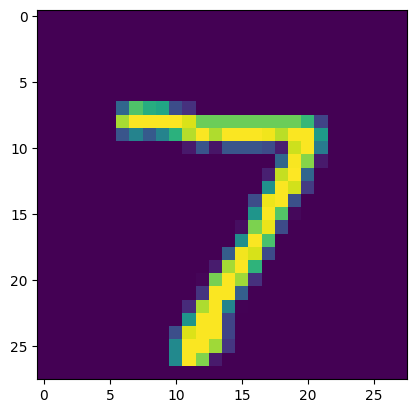

In [34]:
plt.imshow(x)
plt.show()

# MPII Human Pose Dataset

In [4]:
import numpy as np
import pathlib
import scipy.io as spio
from tqdm.auto import tqdm

In [5]:
dataset_url = "https://datasets.d2.mpi-inf.mpg.de/andriluka14cvpr/mpii_human_pose_v1.tar.gz"
archive = keras.utils.get_file(origin=dataset_url, extract=True)
data_dir = pathlib.Path(archive)

In [6]:
path_list = list(data_dir.glob("*/*.jpg"))
n = len(path_list)

In [7]:
mpii_mat = spio.loadmat("mpii_human_pose_v1_u12_1.mat")

In [8]:
mpii_metadata = mpii_mat.get("RELEASE")[0][0]

In [9]:
annolists = mpii_metadata["annolist"][0]
acts = mpii_metadata["act"]

In [11]:
images = []
belong_classes = []

test_images = []

for i in tqdm(range(n)):
    img = keras.utils.load_img(path_list[i])
    img = tf.image.resize(img, (75, 75))

    category = acts[i][0]["cat_name"]
    if category.shape[0] == 0:
        test_images.append(img)
    else:
        images.append(img)
        belong_classes.append(category[0][0])

  0%|          | 0/24984 [00:00<?, ?it/s]

In [12]:
classes_count = list(set(belong_classes))
print(classes_count)
print(len(classes_count))

class_dict = {}
for i in range(len(classes_count)):
    class_dict[classes_count[i]] = i
class_dict

['l', 'w', 'h', 'b', 'm', 'd', 'v', 'o', 't', 'i', 'f', 'c', 'r', 's']
14


{'l': 0,
 'w': 1,
 'h': 2,
 'b': 3,
 'm': 4,
 'd': 5,
 'v': 6,
 'o': 7,
 't': 8,
 'i': 9,
 'f': 10,
 'c': 11,
 'r': 12,
 's': 13}

In [13]:
for i in range(len(belong_classes)):
    belong_classes[i] = class_dict[belong_classes[i]]

In [14]:
belong_classes

[13,
 13,
 13,
 13,
 13,
 13,
 13,
 9,
 9,
 4,
 4,
 4,
 4,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 1,
 9,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 7,
 2,
 7,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 4,
 4,
 0,
 0,
 4,
 4,
 4,
 4,
 4,
 13,
 13,
 13,
 13,
 13,
 12,
 12,
 12,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 7,
 7,
 13,
 13,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 3,
 3,
 3,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 10,
 10,
 10,
 10,
 10,
 10,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 4,
 4,
 4,
 4,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 10,
 10,
 10,
 10,
 10,
 10,
 10

In [24]:
np_images = np.array(images)
np_belong_classes = np.array(belong_classes)

In [64]:
permutation = np.random.permutation(len(np_images))

val_portion = 0.3
train_index = int(np_images.shape[0] * val_portion)

np_train_images = np_images[permutation][:train_index]
np_val_images = np_images[permutation][train_index:]
np_train_classes = np_belong_classes[permutation][:train_index]
np_val_classes = np_belong_classes[permutation][train_index:]

In [38]:
tensor_images = tf.convert_to_tensor(np_images, dtype=tf.float32)
tensor_belong_classes = tf.convert_to_tensor(np_belong_classes, dtype=tf.float32)

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [85]:
epochs = 3
lr = 0.05

In [86]:
np_images.shape

(18032, 75, 75, 3)

In [91]:
model = keras.models.Sequential([
    keras.layers.Conv2D(5, kernel_size=(3, 3), activation='relu', input_shape=(75, 75, 3)),
    keras.layers.Flatten(),
    keras.layers.Dense(14, activation='softmax'),
])

model.compile(
    optimizer=keras.optimizers.AdamW(lr),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

history = model.fit(
    np_train_images,
    np_train_classes,
    epochs=epochs,
    validation_data=(np_val_images, np_val_classes)
)
history = history.history

path = f"models/conv32_3x3_dense14"
if not os.path.isdir(path):
    os.makedirs(path)

get_evaluation(model, history, epochs, np_val_images, np_val_classes, path)

path += f"/conv32_3x3_dense14.tflite"
convert_model(model, path)
generate_cpp(path)

Epoch 1/3


/home/moriogai/.virtualenvs/CVEsp32/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/moriogai/.virtualenvs/CVEsp32/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


170/170 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 105.2013 - sparse_categorical_accuracy: 0.1803 - val_loss: 2.2862 - val_sparse_categorical_accuracy: 0.2039
Epoch 2/3
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.2940 - sparse_categorical_accuracy: 0.1846 - val_loss: 2.2807 - val_sparse_categorical_accuracy: 0.2039
Epoch 3/3
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.2840 - sparse_categorical_accuracy: 0.2052 - val_loss: 2.2802 - val_sparse_categorical_accuracy: 0.2039
395/395 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step - loss: 2.2737 - sparse_categorical_accuracy: 0.2060
[2.28019642829895, 0.20391349494457245]
INFO:tensorflow:Assets written to: /tmp/tmpd1lj84yk/assets


INFO:tensorflow:Assets written to: /tmp/tmpd1lj84yk/assets


Saved artifact at '/tmp/tmpd1lj84yk'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 75, 75, 3), dtype=tf.float32, name='keras_tensor_161')
Output Type:
  TensorSpec(shape=(None, 14), dtype=tf.float32, name=None)
Captures:
  138048237688912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138048237694096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138048237697552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138048237688336: TensorSpec(shape=(), dtype=tf.resource, name=None)


W0000 00:00:1732049808.914801   25429 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1732049808.914813   25429 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
